In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../')
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from data.load import get_patched_data, get_patched_src, subsample, get_data
from data.utils import custom_cutout
from model.metrics import psnr, ssim

## Choose Devices

In [2]:
gpu_id = 3
num_cores = 4

In [3]:
torch.cuda.set_device(gpu_id)

To load the patch critic, loading data is necessary. Is there a way to load the model without loading any data (can we save a good critic not as .pth file but as something else)?

# Feature loss

## Gram loss

In [4]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

## Base loss

In [5]:
base_loss = F.l1_loss

## Resnet Feature loss

### Load data for critic

In [6]:
bs = 8  # batch size
size = 256  # image size
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF')  # path to dataset
lr_dir = f'EM/training/trainsets/lr/'  # input images
hr_dir = f'EM/training/trainsets/hr/'  # target images
critic_path = data_pth/f'EM/models/critics/'

random_patch = partial(custom_cutout, min_n_holes=10, max_n_holes=20,
                       min_length=15, max_length=25, use_on_y=False)

tfms = [[random_patch()], [random_patch()]]

# Create databunch
critic_data = get_patched_data(data_pth, hr_dir, bs, tfms=tfms,
                        in_sz=size, out_sz=size)

### Load critic model

In [7]:
critic_arch = models.resnet34
wd = 1e-3
superres_metrics = [F.mse_loss, psnr, ssim]
critic = unet_learner(critic_data, critic_arch, wd=wd, 
                         #loss_func=feat_loss,
                         loss_func=F.mse_loss,
                         metrics=superres_metrics, 
                         #callback_fns=LossMetrics, 
                         blur=False, 
                         norm_type=NormType.Weight)
gc.collect()

0

In [8]:
critic.model_dir = critic_path
critic = critic.load('critic_patches_resnet_pretrained.2g')

### Define the feature loss class

In [9]:
def next_ind(cur_ind, i):
        ind = cur_ind.copy()
        ind.append(i)
        return ind

def pooling_layer(block, cur_ind=[]):
    """cur_ind: the index of Sequential or BasicBlock that the code is looking into"""
    returned_block = []
    returned_index = []

    for i, k in enumerate(block):
        if isinstance(k, (torch.nn.modules.container.Sequential, torchvision.models.resnet.BasicBlock)):
            new_block, new_index = pooling_layer(k.children(), next_ind(cur_ind, i))
            returned_block.extend(new_block)
            returned_index.extend(new_index)
        elif isinstance(k, torch.nn.modules.conv.Conv2d) and k.stride==(2,2):
            returned_block.append(k)
            returned_index.append(next_ind(cur_ind, i))
    return returned_block, returned_index

def previous_layer(layer_ind):
    prev_layer_list = []
    for ind in layer_ind:
        if not sum(ind):
            continue
        prev_layer = ind.copy()
        prev_layer[-1] -= 1
        if prev_layer[-1] == -1:
            for i in list(range(len(prev_layer)))[::-1]:
                if prev_layer[i] == -1:
                    prev_layer[i-1] -= 1
        prev_layer_list.append(prev_layer)
    return prev_layer_list

In [10]:
encoder = critic.model.eval()[0]
layers, layer_ind = pooling_layer(encoder)
act_blocks = previous_layer(layer_ind)
layers, act_blocks

([Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
  Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
  Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
  Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
  Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False),
  Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
  Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)],
 [[4, -1, -1],
  [5, 0, 4, -1],
  [5, -1, -1],
  [6, 0, 4, -1],
  [6, -1, -1],
  [7, 0, 4, -1]])

In [11]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = self.make_layers(layer_ids)
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_layers(self, layer_ids):
        loss_features = []
        for layer in layer_ids:
            obj = self.m_feat
            for i in layer:
                try:
                    obj = obj[i]
                except TypeError:
                    children = list(obj.children())
                    if len(children):
                        obj = children[i]
                    else:
                        break
            loss_features.append(obj)
        return loss_features
    
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [12]:
feat_loss = FeatureLoss(m_feat=encoder, layer_ids=act_blocks, layer_wgts=[1/6 for _ in range(6)])

# Model

## Initialization

In [13]:
# loading data
nb_name = 'featureloss-resnet34-fresh'
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/')
lr_path = f'EM/training/trainsets/lr/'
hr_path = f'EM/training/trainsets/hr/'
model_path = data_pth/f'EM/models/feat_loss/'
bs = 64
size = 128
data = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs, in_sz=size, out_sz=size, max_zoom=6)
# sub_data = subsample(data)

In [14]:
# model setup
arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, 
                         loss_func=feat_loss,
#                          loss_func=F.mse_loss,
                         metrics=superres_metrics, 
                         #callback_fns=LossMetrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_path)
print(learn.model_dir)

/home/alaa/Dropbox/BPHO Staff/USF/EM/models/feat_loss


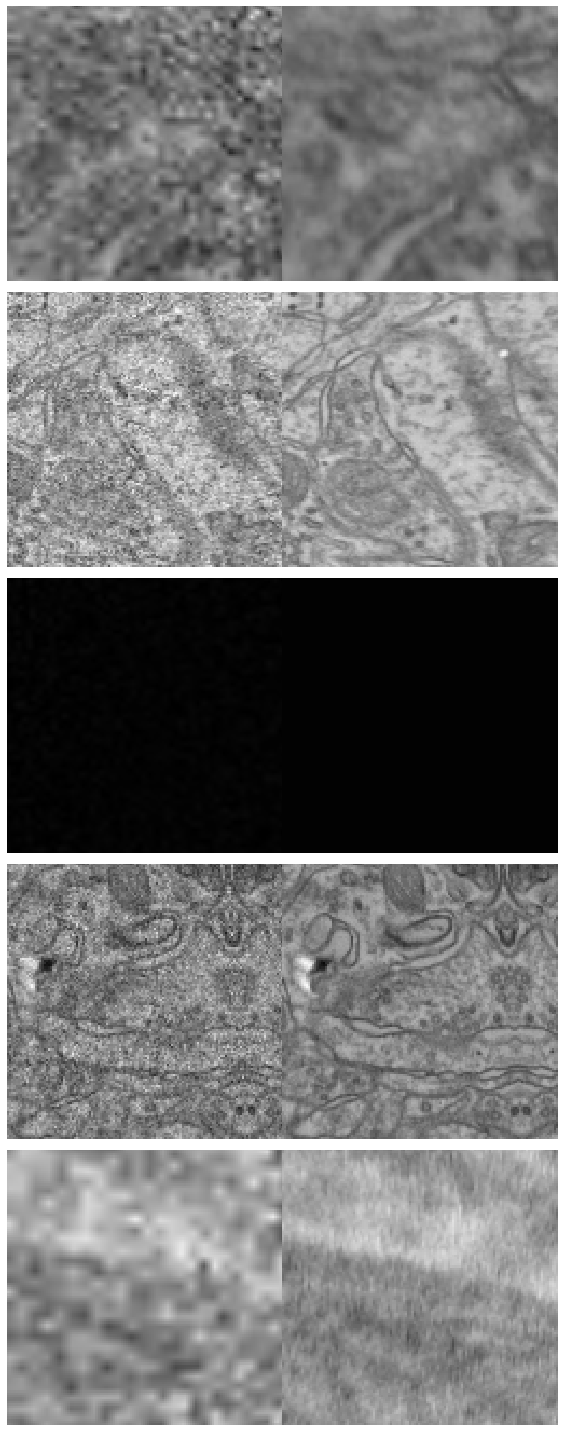

In [16]:
data.show_batch()

## Training

### On subsampled data

### 1a

In [21]:
learn.lr_find()

learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [24]:
lr = 1e-3
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}.1a', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,1.006598,0.533078,0.062537,20.415125,0.570632,01:05


In [25]:
learn.validate()

[0.5330783, tensor(0.0625), tensor(20.4146), tensor(0.5706)]

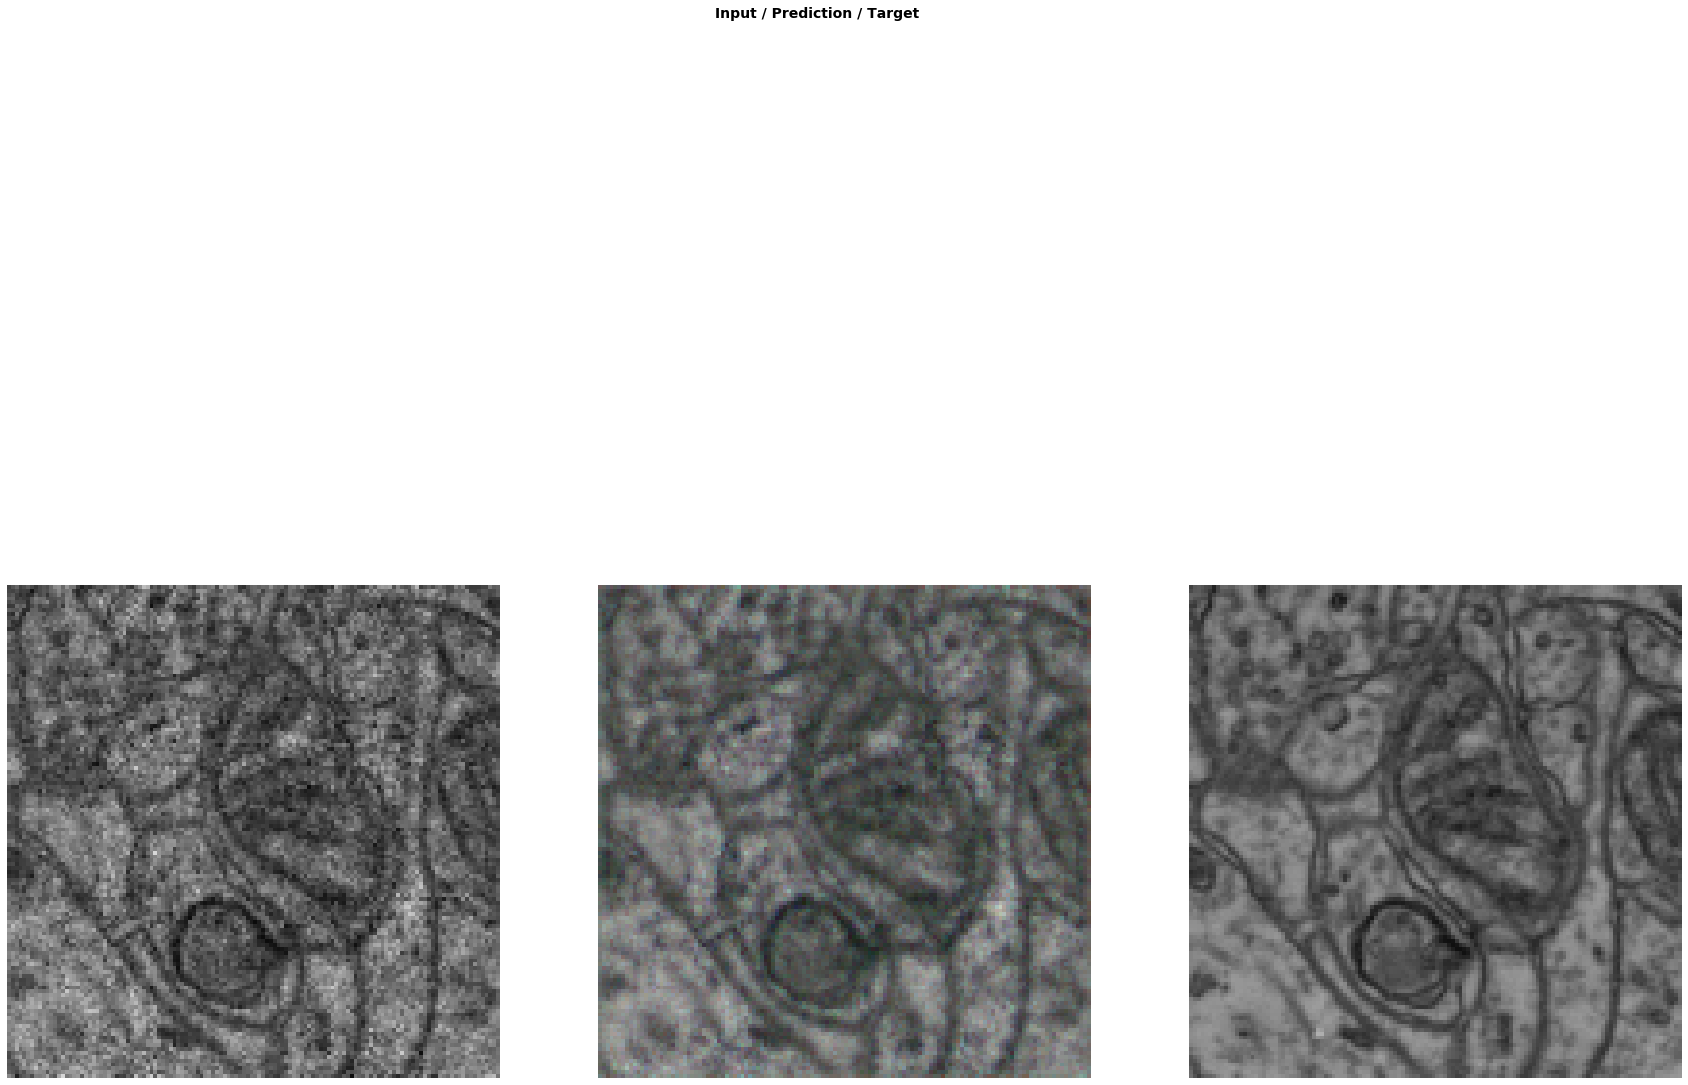

In [26]:
learn.show_results(rows=1, figsize=(30,24))

### 1b

In [27]:
learn.unfreeze()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


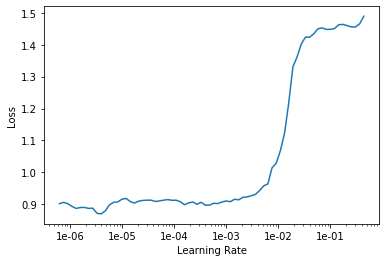

In [29]:
learn.recorder.plot()

In [30]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1b', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.924621,0.505549,0.055044,20.968578,0.612174,01:05
1,0.881062,0.471329,0.048905,21.482416,0.632015,01:04
2,0.828311,0.390075,0.046312,21.714096,0.637492,01:05


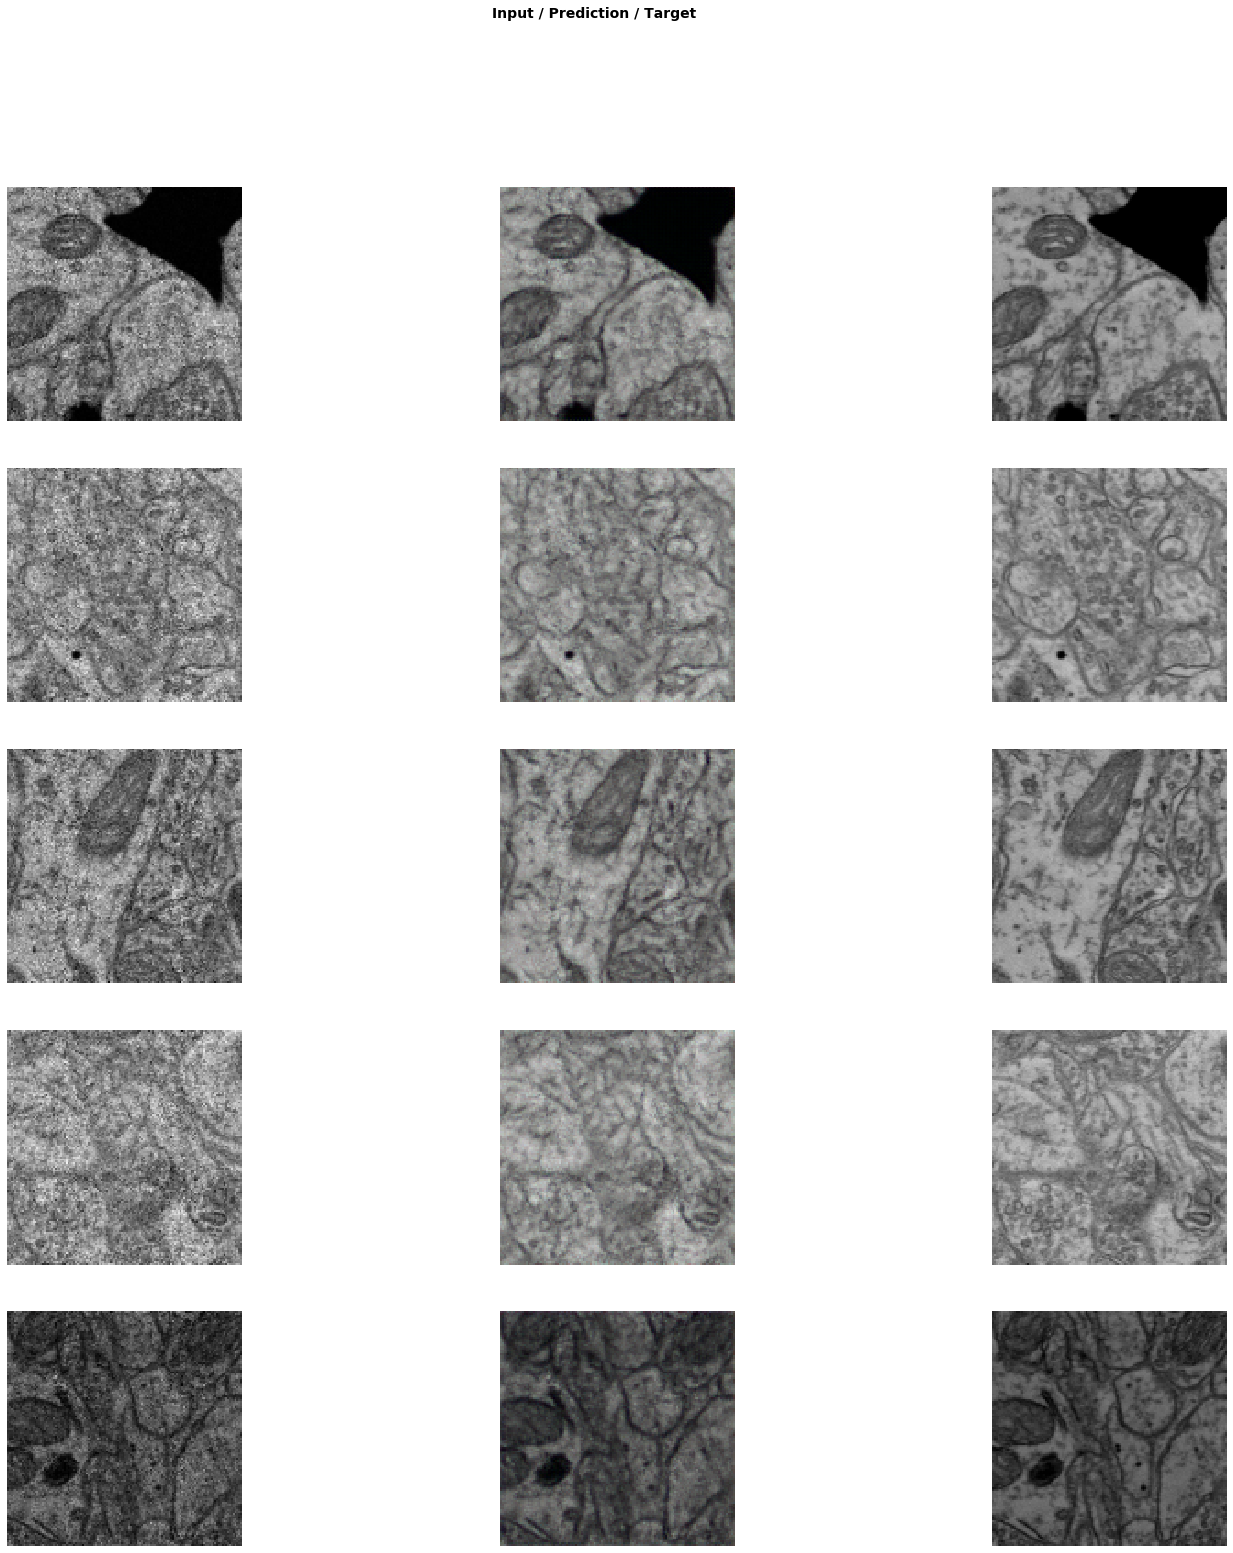

In [34]:
learn.show_results(rows=5, figsize=(25, 25))

### On the whole data

#### 1st round

In [15]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3, pct_start=0.9)
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-5,1e-3), pct_start=0.9)
learn.save(f'{nb_name}.1', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.826602,0.377665,0.043798,21.962563,0.646149,11:22


epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.806066,0.359247,0.042406,22.102831,0.656473,11:25


#### 2nd round

In [16]:
bs_2 = 16
size_2 = 256
db_2 = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_2, in_sz=size_2, out_sz=size_2, max_zoom=3)
learn = unet_learner(db_2, arch, 
                     wd=wd, 
                     loss_func=feat_loss,
#                      loss_func=F.mse_loss,
                     metrics=superres_metrics, 
                     #callback_fns=LossMetrics, 
                     blur=True, norm_type=NormType.Weight, model_dir=model_path)

learn.load(f'{nb_name}.1')
learn.unfreeze()
learn.fit_one_cycle(3, 1e-3, pct_start=0.9)
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-5,1e-3), pct_start=0.9)
learn.save(f'{nb_name}.2', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.769148,0.506685,0.057777,20.737516,0.446874,32:06
1,0.805163,0.522608,0.061509,20.464285,0.448378,31:47
2,0.724947,0.476464,0.055442,20.916960,0.461101,31:48


epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.760985,0.462033,0.056562,20.830029,0.463143,31:49
1,0.765246,0.493979,0.060139,20.562372,0.462088,33:06
2,0.690142,0.455855,0.054940,20.956722,0.467945,31:54


#### 3rd round

In [17]:
bs_3 = 8
size_3 = 512
db_3 = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_3, in_sz=size_3, out_sz=size_3, max_zoom=2.)
learn = unet_learner(db_3, arch, 
                     wd=wd, 
                     loss_func=feat_loss,
#                      loss_func=F.mse_loss,
                     metrics=superres_metrics, 
                     #callback_fns=LossMetrics, 
                     blur=True, norm_type=NormType.Weight, model_dir=model_path)

learn.load(f'{nb_name}.2')
learn.unfreeze()
learn.fit_one_cycle(3, 1e-3, pct_start=0.9)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.944949,0.750020,0.073275,19.653843,0.237361,2:09:43
1,0.880091,0.670704,0.075075,19.549534,0.234323,2:09:25
2,0.787824,0.612680,0.076173,19.485348,0.237329,2:10:08


In [18]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-5,1e-4), pct_start=0.9)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.785789,0.607284,0.076147,19.486794,0.240539,2:09:59
1,0.758048,0.605899,0.076508,19.466139,0.243716,2:09:55
2,0.770983,0.604356,0.075381,19.530939,0.243252,2:09:49


In [19]:
learn.save(f'{nb_name}.3', with_opt=False)